In [1]:
%matplotlib inline
%load_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

In [2]:
%autoreload 1
import taranis.core.nn as ext_nn
from taranis.core.trainer.train import gpu_train, mnist_dataset, gpu_test_model, cifar100_dataset

NOTE: Redirects are currently not supported in Windows or MacOs.


In [3]:
dataset = datasets.MNIST(
    '../data', 
    train=True, 
    download=True
)
print(len(dataset))

image, label = dataset[2]
print(image.size, label)  # A Black and white image is a 2D matrix (28x28)
image

60000
(28, 28) 4


In [4]:


linear = nn.Sequential(
    nn.Flatten(),             
    ext_nn.LinearIdentity(m, n),
    nn.ReLU(),
    ext_nn.LinearIdentity(n, m),
)

batch = transforms.ToTensor()(image)

new = linear(batch).detach().view(28, 28).numpy()

print(new.shape)
plt.matshow(batch.squeeze(0), interpolation=None, cmap='Greys')
plt.matshow(new, interpolation=None, cmap='Greys')
plt.show()

NameError: name 'm' is not defined

In [3]:
# dataset_fast = mnist_dataset()
# dataset_test_fast = mnist_dataset(train=False)

cifar_train = cifar100_dataset(True)
cifar_test = cifar100_dataset(False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = 100
dataset = cifar_train
dataset_test = cifar_test
input_shape = tuple(dataset[0][0].shape)

m = 1
for d in input_shape:
    m *= d
n = m * 2
print(input_shape, m, n)

(3, 32, 32) 3072 6144


In [8]:
# cifar_train[0]

In [9]:
linear = nn.Sequential(
    nn.Flatten(),             
    nn.Linear(m, n),
    nn.ReLU(),
    nn.Linear(n, classes),
    nn.Softmax(dim=1),
)

gpu_train(linear, dataset, lr=1)
gpu_test_model(linear, dataset)
gpu_test_model(linear, dataset_test)

0 -0.001023314678325103
1 -0.001468826515170244
2 -0.0021053627133369446
3 -0.0027714454783843113
4 -0.0033607153365245233
5 -0.003574408017672025
6 -0.003933497632925327
7 -0.00424075355896583
8 -0.00449133263184474
9 -0.004681671754671977
Accuracy: 6.601999999999999 Loss: -0.06168164581298828
Accuracy: 6.59 Loss: -0.06144640884399414


In [ ]:
import taranis.core.nn as ext_nn

linear = nn.Sequential(
    nn.Flatten(),             
    ext_nn.LinearIdentity(m, n),
    nn.ReLU(),
    ext_nn.LinearIdentity(n, classes),
    nn.Softmax(dim=1),
)

gpu_train(linear, dataset, lr=1)
gpu_test_model(linear, dataset_test)

0 -0.0018157086406762784
1 -0.0029788043063420514


In [15]:
import math

linear = nn.Sequential(
    ext_nn.MaskLayer(input_shape, True),
    nn.Flatten(),             
    nn.Linear(m, n),
    nn.ReLU(),
    nn.Linear(n, 10),
    nn.Softmax(dim=1),
)
# nn.init.kaiming_uniform_(list(linear.children())[0].weight, a=math.sqrt(5))


gpu_train(linear, dataset)
gpu_test_model(linear, dataset)
gpu_test_model(linear, dataset_test)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


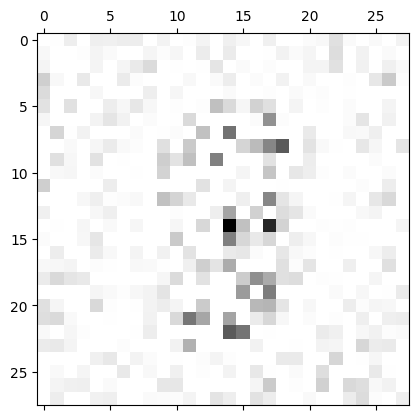

In [17]:
plt.matshow(list(linear.children())[0].weight.detach().cpu(), interpolation=None, cmap='Greys')
plt.show()

In [8]:
linear = nn.Sequential(
    ext_nn.MaskLayer(input_shape, True),
    nn.Flatten(),             
    ext_nn.LinearIdentity(m, n),
    nn.ReLU(),
    ext_nn.LinearIdentity(n, 10),
    nn.Softmax(dim=1),
)
          
gpu_train(linear, dataset)
gpu_test_model(linear, dataset_test)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


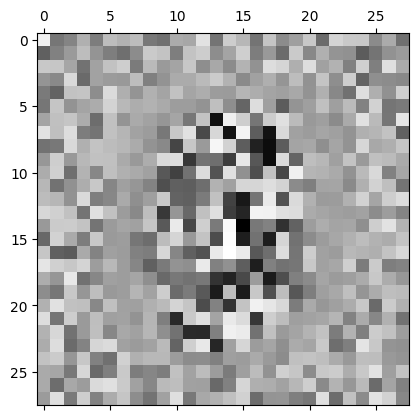

In [13]:
plt.matshow(list(linear.children())[0].weight.detach().cpu(), interpolation=None, cmap='Greys')
plt.show()

In [14]:
list(linear.children())[0].weight.min()

tensor(-0.1497, device='cuda:0', grad_fn=<MinBackward1>)

In [14]:
# mnist_dataset()

In [10]:
dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size = 128,
        num_workers = 0,
    )

In [11]:
b = next(iter(dataloader))
b

[tensor([[[[ 1.8431,  1.8431,  1.8431,  ...,  0.9633,  1.2126,  0.7727],
           [ 1.8431,  1.8284,  1.8284,  ...,  0.5968,  0.4648,  0.2449],
           [ 1.8431,  1.8284,  1.8431,  ...,  0.8754,  0.5381, -0.1217],
           ...,
           [ 0.2742,  0.1862,  0.1569,  ..., -1.4560, -0.9428, -0.7815],
           [-0.1070, -0.1364, -0.0484,  ..., -1.5733, -0.4736,  0.1716],
           [-0.6202, -0.6056, -0.4150,  ..., -1.3974, -0.3563,  0.1276]],
 
          [[ 2.0015,  2.0015,  2.0015,  ...,  1.2370,  1.5275,  1.0688],
           [ 2.0015,  1.9862,  1.9862,  ...,  0.7936,  0.6713,  0.4572],
           [ 2.0015,  1.9862,  2.0015,  ...,  1.1453,  0.8242,  0.1361],
           ...,
           [ 0.9312,  0.8853,  0.8394,  ..., -1.6376, -0.9495, -0.7202],
           [ 0.5031,  0.4725,  0.5489,  ..., -1.6529, -0.1850,  0.5642],
           [-0.0321, -0.0321,  0.1514,  ..., -1.3471,  0.1361,  0.7477]],
 
          [[ 2.0256,  2.0256,  2.0256,  ...,  1.1449,  1.3011,  0.7756],
           [ 

In [13]:
l = ext_nn.MaskLayer(input_shape).cuda()

In [16]:
b[0].shape

torch.Size([128, 3, 32, 32])

In [18]:
l(b[0]).mean()

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)